## View Model
### Imports

In [1]:
import sys
import os
from config import Config
sys.path.append(Config.root_path)

import numpy as np
import tensorflow as tf
# Load Model
from Python.data_processing.compare_predictions import load_model
from Python.model.segmentation_model import deeplabv3plus
# Load Dataset
from Python.data_processing.utils import get_png_paths_from_dir
from Python.data_processing.utils import load_weight_map
from Python.data_processing.data_generator import generate_image_dataset_from_files
# Print Model Prediction
from Python.data_processing.compare_predictions import show_predictions

2023-04-06 23:31:41.727173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 23:31:42.973015: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/vidarmarsh/miniconda3/envs/tf/lib/
2023-04-06 23:31:42.973141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/lib/:/home/vidarmarsh/miniconda3/envs/tf/lib/
2023-04-06 23:31:42.973148: W tens

### Load Model

In [2]:
class MyMeanIoU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(y_true, tf.argmax(y_pred, axis=-1), sample_weight)

model_num = str(7)
model_path = os.path.join(Config.model_dir_path, model_num, "model")
model = load_model(model_path, compile=False)
IOU = MyMeanIoU(
    Config.output_channels,
    ignore_class=Config.background_label
)
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-7),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[IOU],
    weighted_metrics = ["accuracy"]
)

### Load Dataset

In [3]:
image_files = get_png_paths_from_dir(Config.image_path)
mask_files = get_png_paths_from_dir(Config.segmentation_path)
weight_map = load_weight_map(Config.weight_map_path)
weights = np.ones(Config.output_channels, dtype=np.float32)
weights[Config.background_label] = 0

dataset = generate_image_dataset_from_files(
    image_files, 
    mask_files, 
    Config.batch_size,
    tf.data.AUTOTUNE, 
    Config.shuffle_size, 
    weights
)

### Compare Image, Segmentation Mask and Prediction

2023-04-06 23:32:06.771542: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-06 23:32:06.771709: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-06 23:32:06.925926: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-06 23:32:06.926014: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

1/1 [==============================] - 12s 12s/step


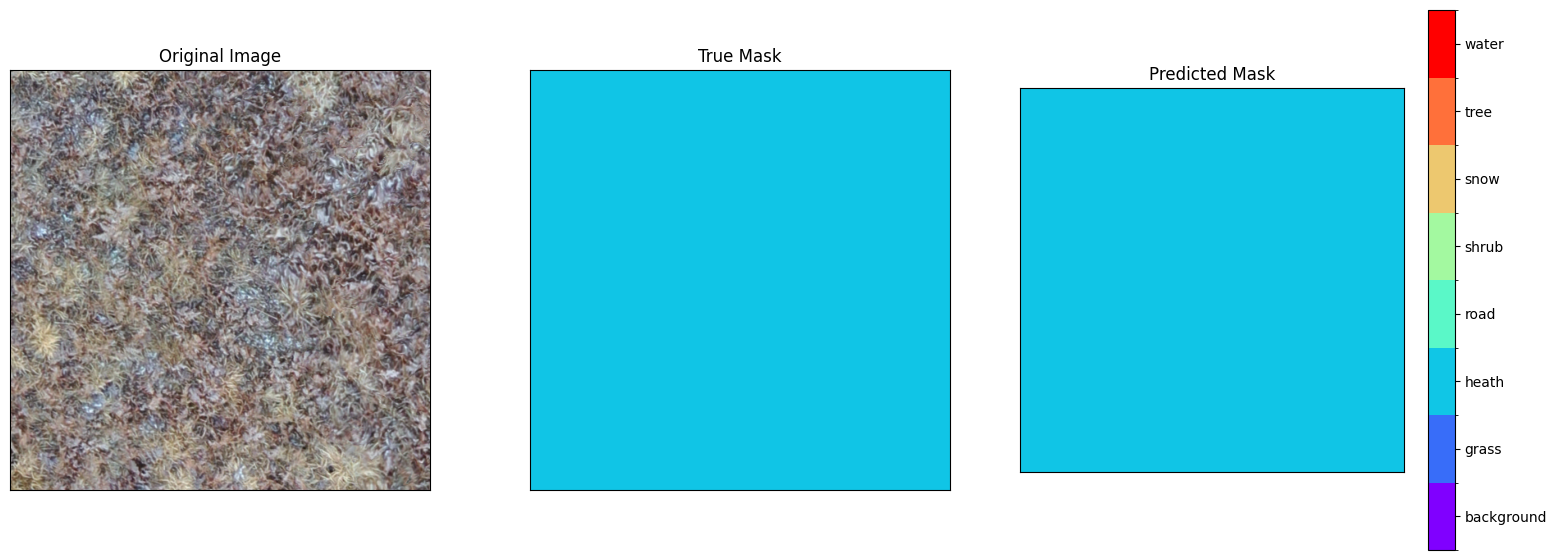

In [4]:
show_predictions(model, dataset)

### Determine Model Performance Metrics

In [5]:
model.evaluate(dataset)

127/127 [==============================] - 21s 119ms/step - loss: 0.1047 - my_mean_io_u: 0.9195 - accuracy: 0.9669


[0.10471448302268982, 0.9194664359092712, 0.9669449925422668]